In [28]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..', 'module'))

In [3]:
import wiki

path_base = '/Users/harangju/Developer/data/wiki/dumps/'
name_xml = 'enwiki-20190801-pages-articles-multistream.xml.bz2'
name_index = 'enwiki-20190801-pages-articles-multistream-index.txt.bz2'
path_xml = path_base + name_xml
path_index = path_base + name_index
dump = wiki.Dump(path_xml, path_index)

In [4]:
topic = 'meteorology'
%time dump.load_page('Index of {} articles'.format(topic))
links = dump.links
dump.links[:5]

Dump: Loading index...
Dump: Loaded.
CPU times: user 1min 14s, sys: 2.41 s, total: 1min 16s
Wall time: 1min 17s


['Meteorology',
 'Interdisciplinary',
 "Earth's atmosphere",
 'Weather',
 'List of meteorological phenomena']

#### Test network generation

In [5]:
import pickle
import gensim.utils as gu

path_save = '/Users/harangju/Developer/data/wiki/models/'
tfidf = gu.SaveLoad.load(path_save + 'tfidf.model')
dct = pickle.load(open(path_save + 'dict.model','rb'))

In [29]:
net = wiki.Net()
net.build_graph(name=topic, dump=dump, nodes=[str(l) for l in links],
                model=tfidf, dct=dct)

wiki.Net: traversing Wikipedia...
wiki.Net: depth = 0
wiki.Net: len(queue) = 269
wiki.Net: depth = 1
wiki.Net: removing isolates...
wiki.Net: adding years...
wiki.Net: filling empty years...
wiki.Net: calculating weights...
wiki.Net: computing core-periphery...
wiki.Net: computing communities...


In [30]:
[len(links), len(net.graph.nodes)]

[771, 523]

In [31]:
net.save_graph(topic)

In [32]:
new_net = wiki.Net()
new_net.load_graph(topic)
len(new_net.graph.nodes)

523

In [33]:
new_net.graph.graph

{'name': 'meteorology',
 'coreness': 0.8559803726733699,
 'modularity': 0.5436774495575821}

In [34]:
[n for n in net.graph.nodes][:5]

['Atmospheric sciences',
 'Meteorology',
 'Atmospheric chemistry',
 'Atmospheric physics',
 'Weather forecasting']

In [35]:
[y for y in net.years][:5]

[-4000, -1500, -650, -426, -364]

In [36]:
net._numbered = None
[n for n in net.numbered.nodes][:5]

[0, 1, 8, 306, 64]

#### Test weighting with tf-idf model

In [37]:
net.graph['Meteorology']

AtlasView({'Advection': {'weight': 0.18022466979139873}, 'Airshed': {'weight': 0.17401933295261143}, 'Anemometer': {'weight': 0.2732645219540093}, 'Atmospheric dispersion modeling': {'weight': 0.2908627096277108}, 'Atmospheric electricity': {'weight': 0.4417092466670953}, 'Baroclinity': {'weight': 0.25324345231204415}, 'Chaos theory': {'weight': 0.30695854384233096}, 'Climate': {'weight': 0.3879762077084722}, 'Cloud': {'weight': 0.29820005121622983}, 'Cloud forcing': {'weight': 0.24009233461350216}, 'Convective available potential energy': {'weight': 0.3086178955082231}, 'Convective inhibition': {'weight': 0.2290024995044583}, 'Convective instability': {'weight': 0.23175751714841555}, 'Cyclone': {'weight': 0.35127786515804216}, 'Dry punch': {'weight': 0.1324607137245272}, 'Equilibrium level': {'weight': 0.2194368977151252}, 'Forensic meteorology': {'weight': 0.42789021164385116}, 'Frontolysis': {'weight': 0.442617154122274}, 'Glossary of tornado terms': {'weight': 0.25481846738033187},

In [38]:
net.graph['Wind']

AtlasView({'List of meteorological phenomena': {'weight': 0.024656055649653248}, 'Anemometer': {'weight': 0.4598547913229778}, 'Climate': {'weight': 0.2738313460534317}, 'Convective instability': {'weight': 0.19854743504306346}, 'Cyclone': {'weight': 0.4003563509248247}, 'Darrieus wind turbine': {'weight': 0.37646834703118415}, 'Fire whirl': {'weight': 0.27434310149182434}, 'Gustnado': {'weight': 0.2559108564787846}, 'Geostrophic wind': {'weight': 0.38384749983511574}, 'Katabatic wind': {'weight': 0.532887497474919}, 'Thunderstorm': {'weight': 0.40907479229507043}, 'Mesoscale convective complex': {'weight': 0.26033738609187373}, 'Outflow boundary': {'weight': 0.4188912627484696}, 'Radiosonde': {'weight': 0.20967185691066775}, 'Storm': {'weight': 0.5278344839765078}, 'Urban heat island': {'weight': 0.3283317665353934}, 'Wind direction': {'weight': 0.662957265411941}, 'Wind gradient': {'weight': 0.6631996001146545}, 'Wind profiler': {'weight': 0.48408088764478197}})

#### Test coreness

In [39]:
net.graph.graph['coreness']

0.8559803726733699

In [40]:
import matplotlib.pyplot as plt

matrix = nx.convert_matrix.to_numpy_array(net.graph,
                                          nodelist=[n for n in net.graph.nodes
                                                    if net.graph.nodes[n]['core']] +
                                                   [n for n in net.graph.nodes
                                                    if not net.graph.nodes[n]['core']])
plt.imshow(matrix)

/anaconda3/envs/wikinet/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/envs/wikinet/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


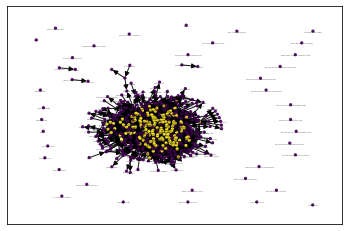

In [41]:
import networkx as nx
pos = nx.drawing.nx_agraph.graphviz_layout(net.graph, prog='neato')
nx.drawing.nx_pylab.draw_networkx(net.graph,
                                  pos,
                                  font_size=0,
                                  alpha=0.9,
                                  node_size=5,
                                  node_color=[net.graph.nodes[n]['core']
                                              for n in net.graph.nodes])

#### Test community structure

In [42]:
net.graph.graph['modularity']

0.5436774495575821

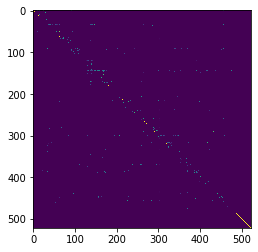

In [43]:
import matplotlib.pyplot as plt

num_communities = max([net.graph.nodes[n]['community'] for n in net.graph.nodes])
nodelist = [[n for n in net.graph.nodes if net.graph.nodes[n]['community']==i]
            for i in range(num_communities)]
nodelist = [n for ns in nodelist for n in ns]
matrix = nx.convert_matrix.to_numpy_array(net.graph,
                                          nodelist=nodelist)
plt.imshow(matrix)

#### Test clique to barcodes

In [44]:
net._cliques = None
%time net.cliques[:4]
%time net.cliques[:4]

CPU times: user 10.6 ms, sys: 521 µs, total: 11.1 ms
Wall time: 10.9 ms
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.01 µs


[[0], [1], [8], [306]]

In [45]:
net.nodes_for_year[-4000]

[9]

In [46]:
%time net.filtration

CPU times: user 1.19 s, sys: 2.5 ms, total: 1.19 s
Wall time: 1.2 s


Filtration with 3460 simplices

In [47]:
%time net.persistence

CPU times: user 2.53 ms, sys: 67 µs, total: 2.6 ms
Wall time: 2.63 ms


Reduced matrix with 3460 columns

In [48]:
net._barcodes = None
%time net.barcodes
%time net.barcodes

wiki.Net: computing barcodes... (skip negatives)
wiki.Net: barcode 3460/3460
CPU times: user 1.13 s, sys: 310 ms, total: 1.44 s
Wall time: 1.26 s
CPU times: user 22 µs, sys: 19 µs, total: 41 µs
Wall time: 45.1 µs


,dim,birth,death,birth simplex,death simplex,birth nodes,death nodes
0,0,-4000,inf,[Hydrology],[],[Hydrology],[]
1,0,-1500,-349.0,[Mercury (element)],"[Thermometer, Mercury (element)]",[Mercury (element)],[Thermometer]
2,0,-650,-350.0,[Weather forecasting],"[Meteorology, Hydrology]",[Weather forecasting],[Meteorology]
3,0,-426,1865.0,[Tsunami],"[Storm surge, Tsunami]",[Tsunami],[Storm surge]
4,0,-364,1599.0,[Sunspot],"[Sun, Sunspot]",[Sunspot],[Sun]
5,0,-363,-363.0,[List of solar cycles],"[List of solar cycles, Sunspot]",[List of solar cycles],[List of solar cycles]
6,0,-350,-350.0,[Meteorology],"[Meteorology, Weather forecasting]",[Meteorology],[Meteorology]
7,0,-349,-349.0,[Rainbow],"[Meteorology, Rainbow]",[Rainbow],[Rainbow]
8,0,-349,-349.0,[Atmospheric dispersion modeling],"[Meteorology, Atmospheric dispersion modeling]",[Atmospheric dispersion modeling],[Atmospheric dispersion modeling]
9,0,-349,-349.0,[Thermometer],"[Meteorology, Thermometer]",[Thermometer],[Thermometer]
